In [ ]:
from google.colab import files

files.upload()

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download qramkrishna/corn-leaf-infection-dataset
!unzip -q corn-leaf-infection-dataset.zip
!rm corn-leaf-infection-dataset.zip

100% 13.0G/13.0G [10:24<00:00, 19.0MB/s]
100% 13.0G/13.0G [10:24<00:00, 22.3MB/s]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import tensorflow as tf

from tensorflow.keras.applications import MobileNetV3Large, MobileNetV2
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocessing

In [ ]:
train_generator = ImageDataGenerator(
                        rescale=1 / 255,
                        validation_split=0.2,
                        rotation_range=30,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        vertical_flip=True,
                        horizontal_flip=True,
                        fill_mode='nearest'
)

valid_generator = ImageDataGenerator(rescale=1 / 255, validation_split=0.2)



train_data_gen = train_generator.flow_from_directory(directory='/content/Corn Disease detection',
                                                     subset='training',
                                                     target_size=(224, 224),
                                                     batch_size=128,
                                                     class_mode='categorical')

val_data_gen = valid_generator.flow_from_directory(directory='/content/Corn Disease detection',
                                                   subset='validation',
                                                   target_size=(224, 224),
                                                   batch_size=128,
                                                   class_mode='categorical')

Found 3380 images belonging to 2 classes.
Found 845 images belonging to 2 classes.


# Load Pre-trained Model

In [ ]:
pre_trained_model = MobileNetV2(weights='imagenet', include_top=False,
                                input_tensor=Input(shape=(224, 224, 3)))
# for layer in pre_trained_model.layers:
#   layer.trainable = False
pre_trained_model.trainable = False



9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
pre_trained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
last_output = pre_trained_model.output

# Change Head

In [ ]:
from tensorflow.keras import regularizers

x = tf.keras.layers.Flatten(name='flatten')(last_output)
# x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.models.Model(pre_trained_model.input, x)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
len(model.trainable_variables)

8

# Compile Model

In [ ]:
initial_lr = 1e-4
num_epochs = 10

optimizer = tf.optimizers.Adam(learning_rate=initial_lr)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training Model

In [ ]:
history = model.fit(train_data_gen,
             epochs=num_epochs,
             validation_data=val_data_gen,
             verbose=1)

Epoch 1/10
27/27 [==============================] - 692s 25s/step - loss: 0.4977 - accuracy: 0.7509 - val_loss: 0.3909 - val_accuracy: 0.8533
Epoch 2/10
27/27 [==============================] - 667s 25s/step - loss: 0.2615 - accuracy: 0.8888 - val_loss: 0.3374 - val_accuracy: 0.8580
Epoch 3/10
27/27 [==============================] - 667s 25s/step - loss: 0.1866 - accuracy: 0.9305 - val_loss: 0.3617 - val_accuracy: 0.8604
Epoch 4/10
27/27 [==============================] - 664s 25s/step - loss: 0.1483 - accuracy: 0.9456 - val_loss: 0.4459 - val_accuracy: 0.8367
Epoch 5/10
27/27 [==============================] - 663s 25s/step - loss: 0.1380 - accuracy: 0.9527 - val_loss: 0.4082 - val_accuracy: 0.8686
Epoch 6/10
27/27 [==============================] - 669s 25s/step - loss: 0.1318 - accuracy: 0.9574 - val_loss: 0.4567 - val_accuracy: 0.8189
Epoch 7/10
27/27 [==============================] - 669s 25s/step - loss: 0.1226 - accuracy: 0.9618 - val_loss: 0.4475 - val_accuracy: 0.8473
Epoch 

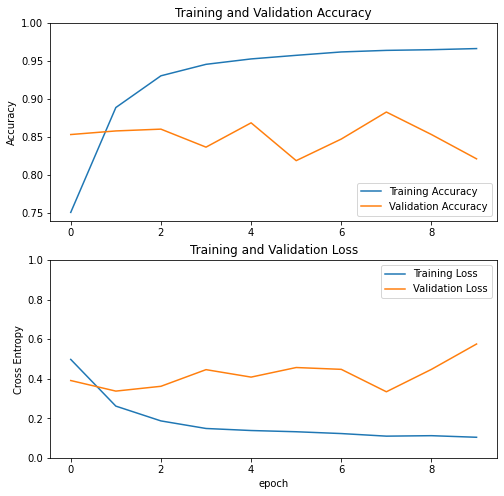

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine Tuning Model

In [ ]:
pre_trained_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(pre_trained_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in pre_trained_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
optimizer = tf.optimizers.Adam(learning_rate=initial_lr/10)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
len(model.trainable_variables)

62

In [ ]:
fine_tune_epochs = 10
total_epochs =  num_epochs + fine_tune_epochs

history_fine = model.fit(train_data_gen,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_data_gen)

Epoch 10/20
27/27 [==============================] - 696s 26s/step - loss: 0.5872 - accuracy: 0.8352 - val_loss: 0.3105 - val_accuracy: 0.8899
Epoch 11/20
27/27 [==============================] - 669s 25s/step - loss: 0.2025 - accuracy: 0.9278 - val_loss: 0.2981 - val_accuracy: 0.8852
Epoch 12/20
27/27 [==============================] - 668s 25s/step - loss: 0.1480 - accuracy: 0.9533 - val_loss: 0.2992 - val_accuracy: 0.8840
Epoch 13/20
27/27 [==============================] - 670s 25s/step - loss: 0.1371 - accuracy: 0.9518 - val_loss: 0.3018 - val_accuracy: 0.8793
Epoch 14/20
27/27 [==============================] - 670s 25s/step - loss: 0.1402 - accuracy: 0.9541 - val_loss: 0.2992 - val_accuracy: 0.8805
Epoch 15/20
27/27 [==============================] - 663s 25s/step - loss: 0.1232 - accuracy: 0.9604 - val_loss: 0.3010 - val_accuracy: 0.8817
Epoch 16/20
27/27 [==============================] - 676s 25s/step - loss: 0.1153 - accuracy: 0.9612 - val_loss: 0.3020 - val_accuracy: 0.8876

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

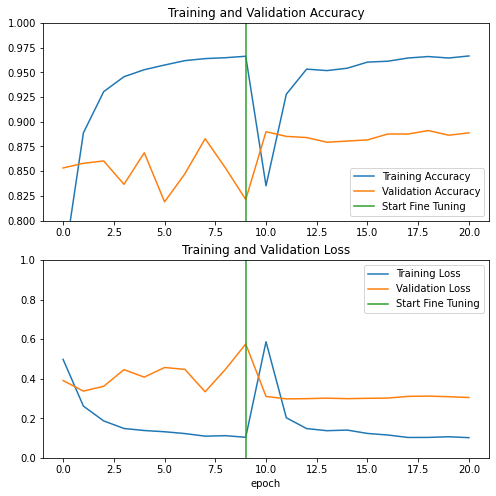

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([num_epochs-1,num_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([num_epochs-1, num_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Save Model

In [ ]:
model.save('model.h5')

In [ ]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

# Convert to TensorFlow Lite

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [ ]:
tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)


16931120

In [ ]:
!ls '/content/Corn Disease detection/Infected' | head -n 5

20200612_103505.jpg
20200612_103531.jpg
20200612_103536.jpg
20200612_103605.jpg
20200612_103610.jpg


In [ ]:
!ls '/content/Corn Disease detection/Healthy corn' | head -n 5

20200610_063438.jpg
20200610_063444.jpg
20200610_063447.jpg
20200610_063449.jpg
20200610_063456.jpg


In [ ]:
!cp '/content/Corn Disease detection/Infected/20200612_103531.jpg' '/content/'